# **5장. 시계열 데이터와 자연어 처리**  

## **5-1절. 시계열 데이터 모델**  

### 라이브러리 불러오기

📌[실습 05-01] 라이브러리 불러오기

In [ ]:
!pip install koreanize_matplotlib
import koreanize_matplotlib
import numpy as np; import pandas as pd
import matplotlib.pyplot as plt; import random
import tensorflow as tf; from tensorflow import keras
from keras.models import Sequential; from keras.layers import Dense, GRU, LSTM
from sklearn.metrics import mean_squared_error, r2_score; import random
from tensorflow.keras.callbacks import Callback, EarlyStopping
from sklearn.preprocessing import MinMaxScaler
import warnings; warnings.filterwarnings('ignore')

📌[실습 05-02] 데이터 불러오기

,day,visitors
0,2020-01-01,455
1,2020-01-02,450
2,2020-01-03,458
3,2020-01-04,567
4,2020-01-05,550
...,...,...
1090,2022-12-26,547
1091,2022-12-27,548
1092,2022-12-28,556
1093,2022-12-29,549


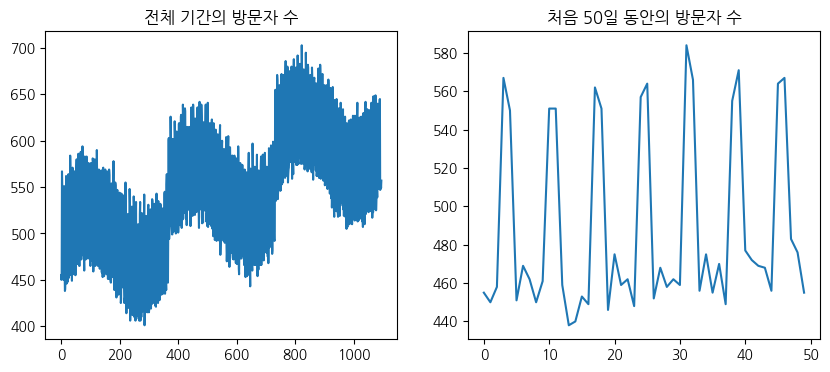

In [ ]:
df=pd.read_csv("방문자수.csv")

# 방문자 수 시각화
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(df['visitors']); plt.title("전체 기간의 방문자 수")
plt.subplot(1, 2, 2)
plt.plot(df['visitors'][:50]); plt.title("처음 50일 동안의 방문자 수")
df

### 시계열 모델로 예측하기  

📌[실습 05-03]시계열 데이터를 전처리하기

In [ ]:
scaler_mm=MinMaxScaler()
df["visitors_mm"]=scaler_mm.fit_transform(df[["visitors"]]) # 정규화 실행
series=np.array(df['visitors_mm'])  # 어레이로 변환
series

array([0.17880795, 0.16225166, 0.18874172, ..., 0.51324503, 0.49006623,
       0.51655629])

📌[실습 05-04] 슬라이딩 윈도우 방식으로 시계열 입력 피처와 타깃 생성하기  

In [ ]:
lag=7  # 입력 시퀀스 길이 설정

# 슬라이딩 윈도우 생성 함수
def create_sliding_window(sequence, window):
    X, y = [], []
    for i in range(window, len(sequence)):
        X.append(sequence[i - window:i])
        y.append(sequence[i])
    return np.array(X), np.array(y)

X, y=create_sliding_window(series, lag)
# 데이터 확인
print(f"피처: shape={X.shape}"); print(X); print()
print(f"타깃: shape={y.shape}"); print(y)

피처: shape=(1088, 7)
[[0.17880795 0.16225166 0.18874172 ... 0.49337748 0.16556291 0.22516556]
 [0.16225166 0.18874172 0.54966887 ... 0.16556291 0.22516556 0.20198675]
 [0.18874172 0.54966887 0.49337748 ... 0.22516556 0.20198675 0.16225166]
 ...
 [0.49006623 0.51324503 0.48675497 ... 0.80794702 0.48344371 0.48675497]
 [0.51324503 0.48675497 0.80463576 ... 0.48344371 0.48675497 0.51324503]
 [0.48675497 0.80463576 0.80794702 ... 0.48675497 0.51324503 0.49006623]]

타깃: shape=(1088,)
[0.20198675 0.16225166 0.1986755  ... 0.51324503 0.49006623 0.51655629]


📌[실습 05-05] 데이터 분할하기  

In [ ]:
from sklearn.model_selection import train_test_split

SEED=42; np.random.seed(SEED); random.seed(SEED); tf.random.set_seed(SEED)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

# 분할 결과 확인
print("x_train 차원=", x_train.shape)
print("y_train 차원=", y_train.shape)
print("x_test 차원=", x_test.shape)
print("y_test 차원=", y_test.shape)


x_train 차원= (870, 7)
y_train 차원= (870,)
x_test 차원= (218, 7)
y_test 차원= (218,)


📌[실습 05-06] GRU 신경망 모델을 설정하고 학습하기

In [ ]:
model=Sequential()
model.add(GRU(32, input_shape=(lag, 1)))
#model.add(LSTM(32, input_shape=(lag, 1)))   # LSTM 레이어로 대체
model.add(Dense(16, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

#조기 종료 조건 설정
early_stop=EarlyStopping(monitor="val_loss", patience=10, verbose=1, restore_best_weights=True)

# 모델 학습시작
history=model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=300, callbacks=[early_stop])


Epoch 1/300
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.2075 - val_loss: 0.0824
Epoch 2/300
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0633 - val_loss: 0.0344
Epoch 3/300
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0336 - val_loss: 0.0328
Epoch 4/300
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0329 - val_loss: 0.0320
Epoch 5/300
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0322 - val_loss: 0.0311
Epoch 6/300
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0311 - val_loss: 0.0298
Epoch 7/300
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0297 - val_loss: 0.0279
Epoch 8/300
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0278 - val_loss: 0.0260
Epoch 9/300
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0256 - val_loss: 0.0233
Epoch 10/300
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0222 - val_loss: 0.0187
Epoch 11/300
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0194 - val_loss: 0.0176
Epoch 12/300
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 

📌[실습 05-07] 학습 과정의 손실 시각화하기

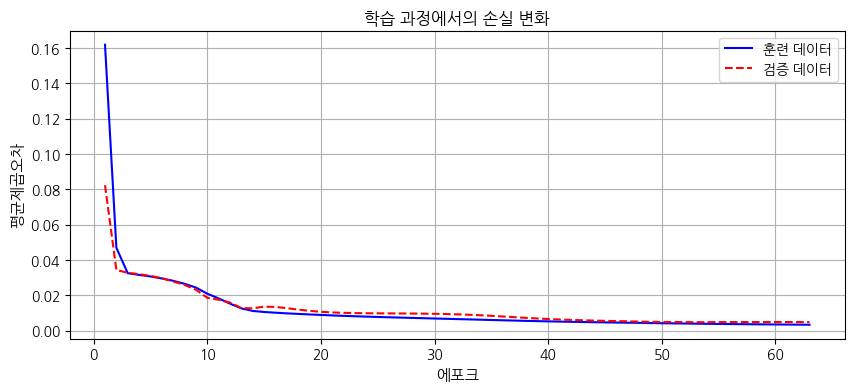

In [ ]:
plt.figure(figsize=(10, 4))

epochs=range(1, len(history.history['loss']) + 1)

plt.plot(epochs, history.history['loss'], label='훈련 데이터', color='blue', linestyle='-')
plt.plot(epochs, history.history['val_loss'], label='검증 데이터', color='red', linestyle='--')
plt.title('학습 과정에서의 손실 변화');
plt.xlabel('에포크', fontsize=11); plt.ylabel('평균제곱오차', fontsize=11);
plt.legend(); plt.grid(); plt.show()


📌[실습 05-08] 학습된 모델의 예측 성능 확인하기

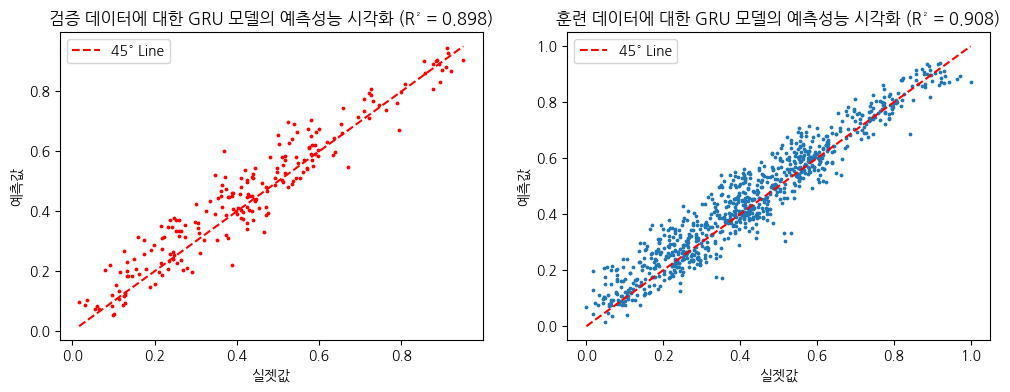

In [ ]:
plt.figure(figsize=(12, 4))

# 검정용 데이터
plt.subplot(1, 2, 1)
y_pred=model.predict(x_test, verbose=0)  # verbose=0은 출력없이 예측만 실행
y=y_test
acc=r2_score(y, y_pred)  # R²예측력 계산
plt.scatter(y, y_pred, color="r", s=3)
plt.plot([y.min(), y.max()], [y.min(), y.max()], color="red", linestyle="--", label="45° Line")
plt.title(f"검증 데이터에 대한 GRU 모델의 예측성능 시각화 (R² = {acc:.3f})")
plt.xlabel("실젯값"); plt.ylabel("예측값"); plt.legend()

# 훈련용 데이터
plt.subplot(1, 2, 2)
y_pred=model.predict(x_train, verbose=0)
y=y_train
acc = r2_score(y, y_pred)  # R²예측력 계산
plt.scatter(y, y_pred, s=3)
plt.plot([y.min(), y.max()], [y.min(), y.max()], color="red", linestyle="--", label="45° Line")
plt.title(f"훈련 데이터에 대한 GRU 모델의 예측성능 시각화 (R² = {acc:.3f})")
plt.xlabel("실젯값"); plt.ylabel("예측값"); plt.legend()
plt.show()

GRU 기반 시계열 예측 함수 정의하기  

📌[실습 05-09] GRU 기반 시계열 예측 함수 정의하기

In [ ]:
## 학습된 모형으로 미래의 타겟변수를 순차적으로 예측하는 함수 지정
def forecast(y, step):
  output=[]
  recent=y[-lag:] # 첫번째 예측의 피처는 가장 최근의 7일 방문자 (lag는 모형설정과 같아야 함!)
  for _ in range(step):
      pred=model.predict(recent.reshape(1, lag), verbose=0)
      output.append(pred)
      recent = np.concatenate((np.ravel(recent[1:]),np.ravel(pred)))  # 슬라이딩 윈도우 재조정
  return output

📌[실습 05-10] 예측 결과 및 스케일 복구하기  

In [ ]:
K=15   # 예측 기간 설정
q=np.ravel(forecast(y=series, step=K)) #예측
q_original=scaler_mm.inverse_transform(q.reshape(-1,1)) # 원래 스케일로 복구
w=pd.DataFrame(q_original, columns=["미래 예측"])       # 예측값을 데이터프레임 형식으로
w[:5]

,미래 예측
0,648.239319
1,651.692932
2,574.028687
3,558.761597
4,555.816772


📌[실습 05-11] 예측 결과 시각화하기

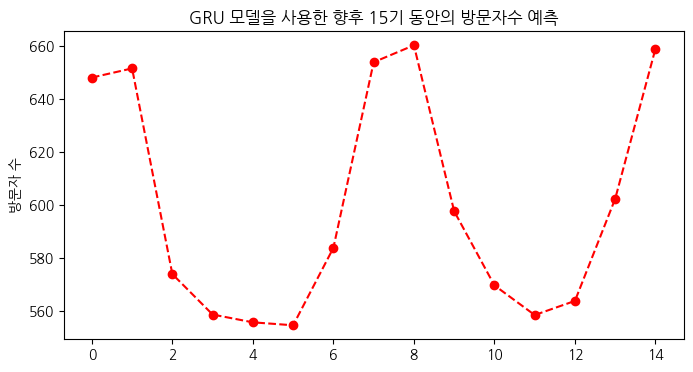

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(q_original, "ro--")
plt.ylabel('방문자 수')
plt.title("GRU 모델을 사용한 향후 15기 동안의 방문자수 예측")
plt.show()

### **합성곱 신경망을 사용한 시계열 예측**

📌[실습 05-12] GRU 대신 CNN을 사용하여 시계열 예측 모델 설정하기

In [ ]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten

model_cnn=Sequential()
model_cnn.add(Conv1D(32, 3, activation='relu', padding='same', input_shape=(lag, 1)))
model_cnn.add(MaxPooling1D(2))
model_cnn.add(Flatten())
model_cnn.add(Dense(16, activation='relu'))
model_cnn.add(Dense(1))
model_cnn.compile(optimizer='adam', loss='mse')

#조기 종료 조건
early_stop=EarlyStopping(monitor="val_loss", patience=10, verbose=1, restore_best_weights=True)

# 학습시작
history=model_cnn.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=300, callbacks=[early_stop])


📌 CNN 모델의 예측 정확도 시각화하기

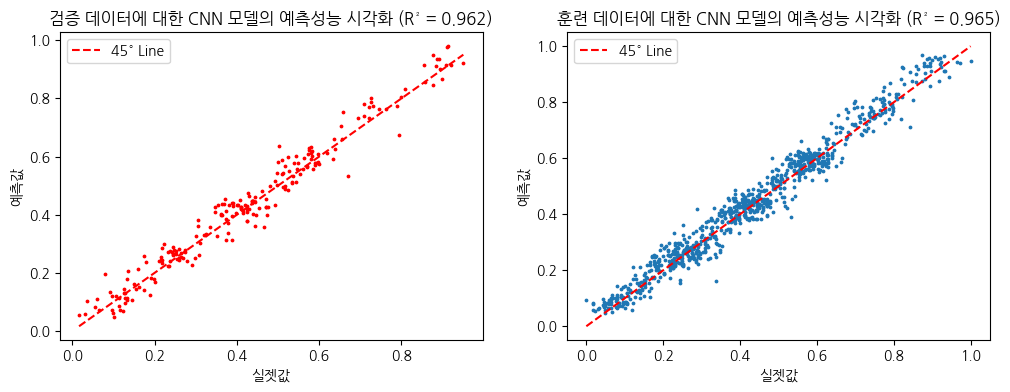

In [ ]:
plt.figure(figsize=(12, 4))

# 검정용 데이터
plt.subplot(1,2,1)
y_pred=model_cnn.predict(x_test, verbose=0)  # verbose=0은 출력없이 예측만 실행
y=y_test
acc=r2_score(y, y_pred)  # R²예측력 계산
plt.scatter(y, y_pred, color="r", s=3)
plt.plot([y.min(), y.max()], [y.min(), y.max()], color="red", linestyle="--", label="45° Line")
plt.title(f"검증 데이터에 대한 CNN 모델의 예측성능 시각화 (R² = {acc:.3f})")
plt.xlabel("실젯값"); plt.ylabel("예측값"); plt.legend()

# 훈련용 데이터
plt.subplot(1,2,2)
y_pred=model_cnn.predict(x_train, verbose=0)
y=y_train
acc=r2_score(y, y_pred)  # R²예측력 계산
plt.scatter(y, y_pred, s=3)
plt.plot([y.min(), y.max()], [y.min(), y.max()], color="red", linestyle="--", label="45° Line")
plt.title(f"훈련 데이터에 대한 CNN 모델의 예측성능 시각화 (R² = {acc:.3f})")
plt.xlabel("실젯값"); plt.ylabel("예측값"); plt.legend()
plt.show()